In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import scipy.optimize, scipy.signal
import math

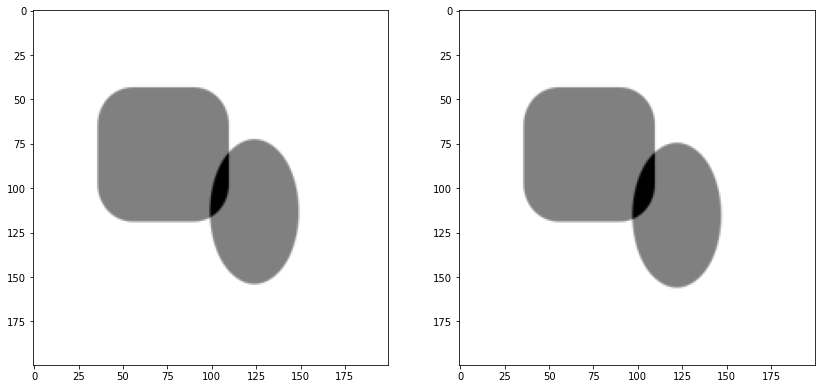

In [2]:
#Read Images
# I1 = cv.imread("./Images/Image_A1.png", 0)
# I2 = cv.imread("./Images/Image_A2.png", 0)

I1 = cv.imread("./Images/Image_RO1.png", 0)
I2 = cv.imread("./Images/Image_RO2.png", 0)

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].imshow(I1, "gray")
axs[1].imshow(I2, "gray")
plt.show()

In [3]:
def imgradient(I):
    # Find x and y gradients
#     Kx = np.array([[-1,0,1]])
#     Ky = np.transpose(Kx)
#     sobelx = scipy.signal.convolve2d(I,Kx,'same')
#     sobely = scipy.signal.convolve2d(I,Kx,'same')
    sobelx = cv.Sobel(I,cv.CV_64F,1,0) 
    sobely = cv.Sobel(I,cv.CV_64F,0,1)

    # Find magnitude
    magnitude = np.sqrt(sobelx**2.0 + sobely**2.0)
    return magnitude

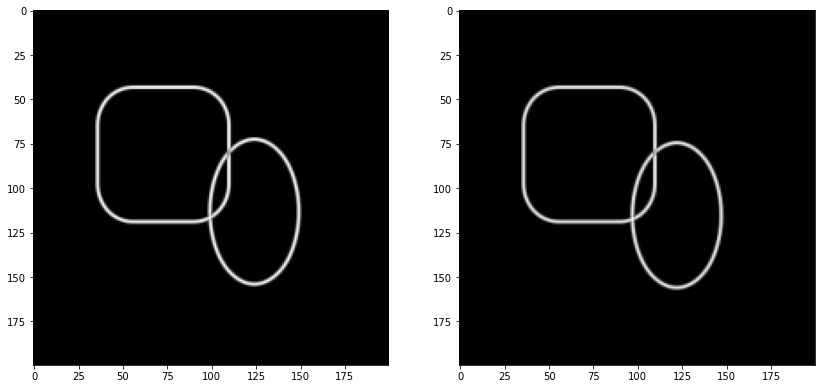

In [4]:
#Gradient of the images
I1_grad = imgradient(I1)
I2_grad = imgradient(I2) 

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].imshow(I1_grad, "gray")
axs[1].imshow(I2_grad, "gray")
plt.show()

In [5]:
I1.shape

(200, 200)

In [6]:
I1_grad

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
I2_grad

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Warping

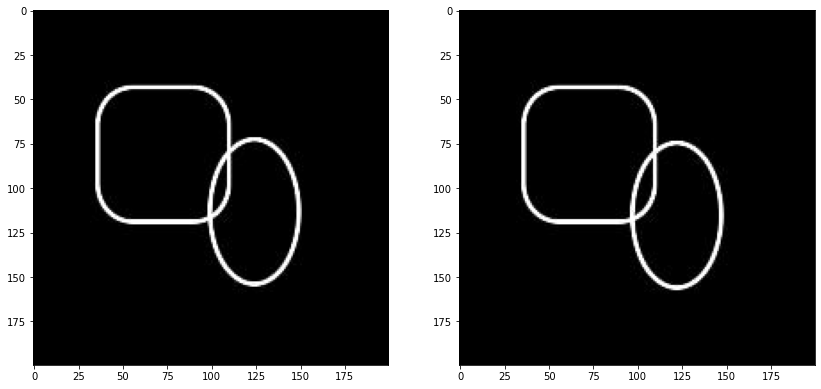

In [8]:
#gradient of images after preprocessing
# G1 = cv.imread("./Images/Gradient/Image_A1_gradient.jpg", 0)
# G2 = cv.imread("./Images/Gradient/Image_A2_gradient.jpg", 0)

G1 = cv.imread("./Images/Gradient/Image_RO1_gradient.jpg", 0)
G2 = cv.imread("./Images/Gradient/Image_RO2_gradient.jpg", 0)

G1 = np.array(G1, dtype='int64')
G2 = np.array(G2, dtype='int64')

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].imshow(G1, "gray")
axs[1].imshow(G2, "gray")
plt.show()

In [9]:
im_list = ["RO1","RO2","RO3","RO4","RO5"]

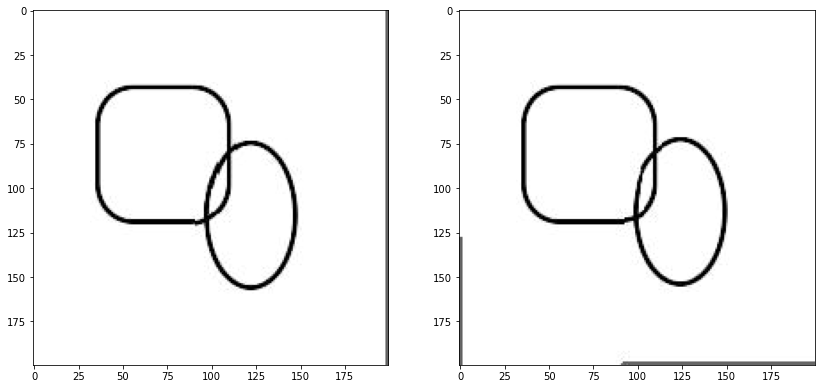

In [10]:
#warped gradients
# G1_w_I2 = cv.imread("./Images/Warped_Gradient/Image_A1_gradient_w_A2.jpg", 0)
# G2_w_I1 = cv.imread("./Images/Warped_Gradient/Image_A2_gradient_w_A1.jpg", 0)

G1_w_I2 = cv.imread("./Images/Warped_Gradient/Image_RO1_gradient_w_RO2.jpg", 0)
G2_w_I1 = cv.imread("./Images/Warped_Gradient/Image_RO2_gradient_w_RO1.jpg", 0)

# G_w_I={}
# for i in range(len(im_list)):
#     for j in range(len(im_list)):
#         G_w_I[f"G{i+1}_w_I{j+1}"] = cv.imread(f"./Images/Warped_Gradient/Image_{im_list[i]}_gradient_w_{im_list[j]}.jpg", 0)

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].imshow(G1_w_I2, "gray_r")
axs[1].imshow(G2_w_I1, "gray_r")
# axs[0].imshow(G_w_I['G1_w_I2'], "gray_r")
# axs[1].imshow(G_w_I['G2_w_I1'], "gray_r")
plt.show()

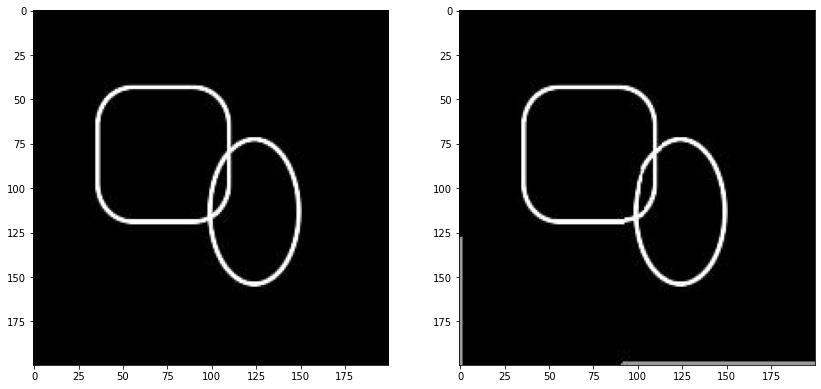

In [11]:
# Gradient 1 and warped Gradient 2
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].imshow(G1, "gray")
axs[1].imshow(G2_w_I1, "gray")
plt.show()

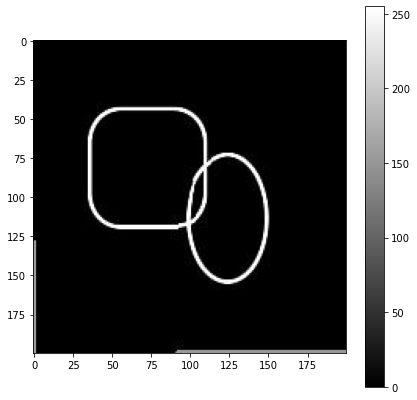

In [12]:
plt.figure(figsize=(7,7))
plt.imshow(G2_w_I1, "gray")
plt.colorbar()
plt.show()

## Edge Separation

### Change is scale and center

In [13]:
def sigmoid(t):
    #return 1/(1 + np.exp(-(t-0.05)/0.05))
    t_avg = (t.max()+t.min())/2
    return 1/(1 + np.exp(-(t-t_avg)/0.05))

### Changed the "zero" condition

In [14]:
def Phi(a,b):
    phi = np.empty(a.shape)
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            if ((a[i,j] + b[i,j])**2 ==0): 
                phi[i,j] = 0  #.5  
            else:
                phi[i,j] = (a[i,j]**2 + b[i,j]**2)/((a[i,j] + b[i,j])**2)
                
    print(phi.max(),phi.min())
    return (phi -0.5)*2

In [15]:
np.min(Phi(G1,G2_w_I1))

1.0 0.0


-1.0

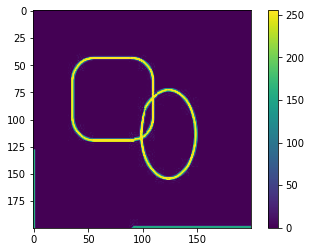

In [16]:
plt.imshow(G2_w_I1)
plt.colorbar()

1.0 0.0
1.0 0.0


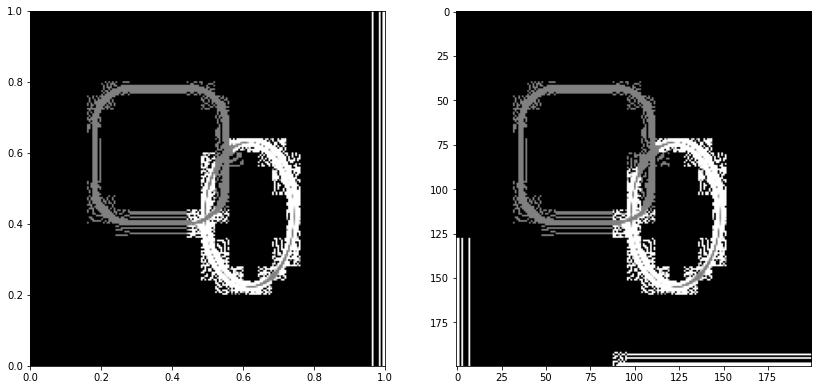

In [17]:
#Probability of foreground (reflection): P_F and background: P_B
P_F1 = sigmoid(Phi(G1/255,G1_w_I2/255))
P_B1 = 1 - P_F1

P_F2 = sigmoid(Phi(G2_w_I1/255,G2/255))
P_B2 = 1 - P_F2

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].imshow(P_F1, "gray",extent=[0,1,0,1])
axs[1].imshow(P_F2, "gray")
plt.show()



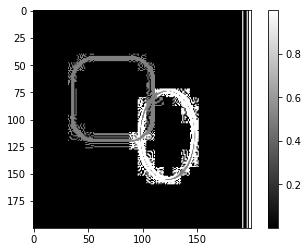

In [18]:
plt.imshow(P_F1,"gray")
plt.colorbar()
plt.show()

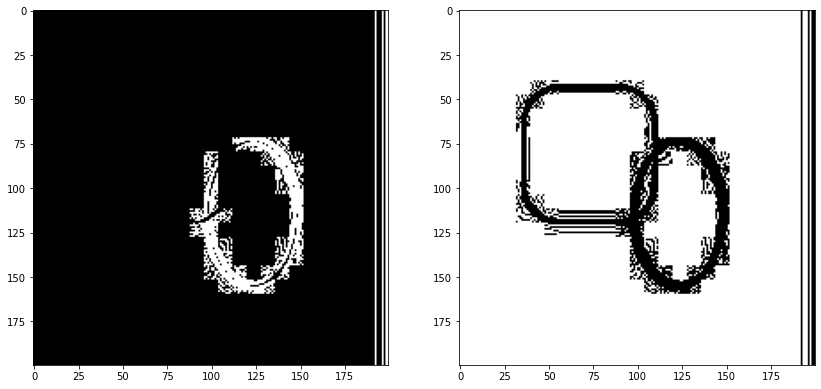

In [19]:
# Tresholding images according to probability values to obtain edges of foreground and background
threshold_p = 0.6

E_F1 = np.empty(I1_grad.shape)
for i in range(I1_grad.shape[0]):
    for j in range(I1_grad.shape[1]):
        if P_F1[i,j] > threshold_p: 
            E_F1[i,j] = 1
        else:
            E_F1[i,j] = 0

E_B1 = np.empty(I1_grad.shape)
for i in range(I1_grad.shape[0]):
    for j in range(I1_grad.shape[1]):
        if P_B1[i,j] > threshold_p: 
            E_B1[i,j] = 1
        else:
            E_B1[i,j] = 0
                
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].imshow(E_F1, "gray")
axs[1].imshow(E_B1, "gray")
plt.show()

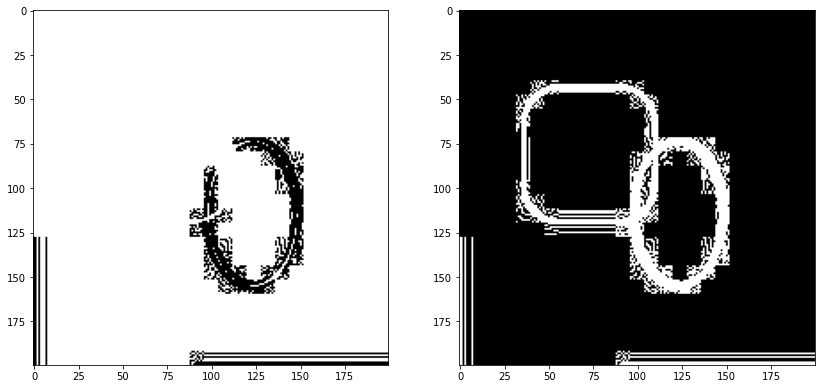

In [20]:
E_F2 = np.empty(I2_grad.shape)
for i in range(I2_grad.shape[0]):
    for j in range(I1_grad.shape[1]):
        if P_F2[i,j] > threshold_p: 
            E_F2[i,j] = 0
        else:
            E_F2[i,j] = 1

E_B2 = np.empty(I2_grad.shape)
for i in range(I2_grad.shape[0]):
    for j in range(I1_grad.shape[1]):
        if P_B2[i,j] > threshold_p: 
            E_B2[i,j] = 0
        else:
            E_B2[i,j] = 1
                
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].imshow(E_F2, "gray")
axs[1].imshow(E_B2, "gray")
plt.show()

In [21]:
I1.shape

(200, 200)